In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from numba import njit

plt.rcParams['font.size'] = 14

# Primary Functions

In [2]:
@njit
def energyI(box, h=0, J=1):
    '''
    Returns energy of a 2D Ising lattice of spins, where the energy per bond is the product of the spins making the bond
    
    PARAMETERS:
    -----------
     • box: 2D (shape (x, y)) lattice of spins
     • h: External magnetic field; set by default to 0
     • J: Interaction energy; set by default to 1
     
    RETURNS:
    --------
     • e: Energy of the lattice, a number
    '''
    
    x,y = box.shape
    eJ = 0 # Initialising interaction energy
    eH = 0 # Initialising external magnetic field energy
    for i in range(x):
        for j in range(y):
            sides = box[i-1,j] + box[i,j-1] # By the loop over every particle, this loops over every bond
            eJ -= box[i,j]*sides
            eH -= box[i,j]
    eJ *= J
    eH *= h
    e = eJ + eH
    
    return e

#------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------

@njit
def kronecker(spin1, spin2):
    '''
    Returns energy of a pair of spins on a q-Potts lattice
    
    PARAMETERS:
    -----------
     • spin1: Spin 1 of the pair, an integer between 0 and q-1
     • spin2: Spin 2 of the pair, an integer between 0 and q-1
    
    RETURNS:
    --------
     • Energy of the pair: 1 if the spins are the same, and 0 if they are not
    '''

    if int(spin1)==int(spin2):
        return 1
    else:
        return 0

@njit
def eng(spins,i,j,L,J=1):
    '''
    Returns energy of a spin on a q-Potts lattice
    
    PARAMETERS:
    -----------
     • spins: 2D (shape (x, y)) lattice of spins
     • i: x-coordinate of spin whose energy is to be determined
     • j: y-coordinate of spin whose energy is to be determined
     • L: Length of the lattice
     • J: Interaction energy; set by default to 1
    
    RETURNS:
    --------
     • Energy of the spin: a number
    '''

    energy=(kronecker(spins[i][j],spins[(i+1)%L][j])+kronecker(spins[i][j],spins[i][(j+1)%L])+kronecker(spins[i][j],spins[i][j-1])+kronecker(spins[i][j],spins[i-1][j]))

    return -J*energy

#------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------

@njit
def energyH(box, hz=0, J=1):
    '''
    Returns energy of a 2D Classical Heisenberg lattice of spins, where the energy per bond is the dot product of the spins making the bond
    
    PARAMETERS:
    -----------
     • box: 3D (shape (x, y, 3)) lattice of spins [2D Lattice, third dimension for components of vector spins]
     • h: External magnetic field in the z-direction; set by default to 0
     • J: Interaction energy; set by default to 1
    
    RETURNS:
    --------
     • e: Energy of the lattice, a number
    '''
    
    x,y = box.shape[:2]
    eJ = 0 # Initialising interaction energy
    eH = 0 # Initialising external magnetic field energy
    for i in range(x):
        for j in range(y):
            sides = box[i-1,j] + box[i,j-1] # By the loop over every particle, this loops over every bond
            eJ -= np.sum(box[i,j]*sides)
            eH -= box[i,j,2]
    eJ *= J
    eH *= hz
    e = eJ + eH
    
    return e

In [3]:
@njit
def magnetI(box):
    '''
    Returns magnetisation of a 2D Ising lattice of spins.
    
    PARAMETERS:
    -----------
     • box: 2D (shape (x, y)) lattice of spins
     
    RETURNS:
    --------
     • m: The sum of all spins of the lattice, a number
    '''    
    
    x,y = box.shape[:2]
    m = 0 # Initialising sum of all spins
    for i in range(x):
        for j in range(y):
            m += box[i,j]
    
    return m

#------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------

@njit
def magnetQ(box):
    '''
    Returns magnetisation of a 2D q-Potts lattice of spins.
    
    PARAMETERS:
    -----------
     • box: 3D (shape (x, y, 2)) lattice of spins
     
    RETURNS:
    --------
     • m: The sum of all spins of the lattice, a 1D array with the 2 elements
    '''    
    
    x,y = box.shape[:2]
    m = np.array([0.,0.]) # Initialising sum of all spins
    for i in range(x):
        for j in range(y):
            m += box[i,j]
    
    return m

#------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------

@njit
def magnetH(box):
    '''
    Returns magnetisation of a 2D Classical Heisenberg lattice of spins.
    
    PARAMETERS:
    -----------
     • box: 3D (shape (x, y, 3)) lattice of spins
     
    RETURNS:
    --------
     • m: The sum of all spins of the lattice, a 1D array with 3 elements
    '''    
    
    x,y = box.shape[:2]
    m = np.array([0.,0.,0.]) # Initialising sum of all spins
    for i in range(x):
        for j in range(y):
            m += box[i,j]
    
    return m

In [4]:
@njit
def montecarloI(box, T, h=0, J=1):
    '''
    Performs one Monte Carlo sweep at a given temperature over a 2D Ising lattice of spins.
    
    PARAMETERS:
    -----------
     • box: 2D (shape (x, y)) lattice of spins
     • T: Temperature at which Monte Carlo sweep is performed
     • h: External magnetic field; set by default to 0
     • J: Interaction energy; set by default to 1
     
    RETURNS:
    --------
     • box: The lattice after one Monte Carlo sweep has been performed, a 3D array of the same shape as the input box
     • en: The energy of the new lattice, a number
     • mag: The sum of all spins of the new lattice, a number
    '''
    
    x,y = box.shape
    en = energyI(box, h=h, J=J)
    mag = magnetI(box)
    
    for p in range(x*y):
        i = int(x*np.random.uniform(0,1)) # Choosing a random x-coordinate in the lattice
        j = int(y*np.random.uniform(0,1)) # Choosing a random y-coordinate in the lattice
        
        nlatij = -box[i,j] # Trial is flip of random spin
        
        sides = box[(i+1)%x,j] + box[(i-1)%x,j] + box[i,(j+1)%y] + box[i,(j-1)%y] # Sum
        dE = -J*(nlatij - box[i,j])*sides - h*(nlatij - box[i,j]) # Change in energy from trial flip/rotation
        
        if dE <= 0: # Trials lowering energies are always accepted
            en += dE
            mag += -box[i,j] + nlatij
            box[i,j] = nlatij
        else:
            r = np.random.uniform(0,1)
            if r <= np.exp(-dE/T): # Trials increasing energy are accepted with a probability from the Boltzmann distribution
                en += dE
                mag += -box[i,j] + nlatij
                box[i,j] = nlatij

    return box, en, mag

#------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------

@njit                                     
def oneMCS(energy, beta, spins,q, J=1):
    '''
    Performs one Monte Carlo sweep at a given temperature over a 2D q-Potts lattice of spins.
    
    PARAMETERS:
    -----------
     • energy: Energy of the lattice of spins
     • beta: Inverse temperature at which Monte Carlo sweep is performed
     • spins: 2D (shape (x, y)) lattice of spins
     • q: Number of states for q-Potts model
     • J: Interaction energy; set by default to 1
     
    RETURNS:
    --------
     • energy: The energy of the new lattice, a number
     • spins: The lattice after one Monte Carlo sweep has been performed, a 2D array of the same shape as the input spins
    '''

    L = np.shape(spins)[0]                # Linear dimension of our square lattice
    N = L**2  # Number of spins
    #energy=0
    for nothing in range(N): #running a loop over all the spins
        
        
        i=int(L*np.random.uniform(0,1))# choosing a coordinate in x
        j=int(L*np.random.uniform(0,1)) #choosing a coordinate in y
        ns=int(q*np.random.uniform(0,1))
        #print(ns)
        temp=spins[i,j]
        E_i=eng(spins,i,j,L)
        #dE=2*J*spins[i,j]*(spins[(i+1)%L,j]+spins[(i-1)%L,j]+spins[i,(j+1)%L]+spins[i,(j-1)%L])+2*h*spin[i,j]
        # using boundary condition we can calculate the change in energy if the spin is flipped, the factor of 2 comes from subtracting final energy from initial 
        spins[i,j]=ns
        E_f=eng(spins,i,j,L)
        
        dE=E_f-E_i
        
        e=np.exp(-dE*beta) #defining the probability of acceptance
        r=np.random.uniform(0,1)# calling a random uniform number
        #check if dE is less than equal to 0 or not, if yes then increment the change and flip the spins
        if dE<=0 or r<e:
            energy += dE
            spins[i,j]=ns 
            
        else:
            spins[i,j]=temp
                
    return energy, spins #return energy and spin configuration after oneMCS


#------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------

@njit
def montecarloH(box, T, hz=0, J=1):
    '''
    Performs one Monte Carlo sweep at a given temperature over a 2D Classical Heisenberg lattice of spins.
    
    PARAMETERS:
    -----------
     • box: 3D (shape (x, y, 3)) lattice of spins
     • T: Temperature at which Monte Carlo sweep is performed
     • hz: External magnetic field in the z-direction; set by default to 0
     • J: Interaction energy; set by default to 1
     
    RETURNS:
    --------
     • box: The lattice after one Monte Carlo sweep has been performed, a 3D array of the same shape as the input box
     • en: The energy of the new lattice, a number
     • mag: The sum of all spins of the new lattice, a 1D array with 3 elements
    '''
    
    x,y = box.shape[:2]
    en = energyH(box, hz=hz, J=J)
    mag = magnetH(box)
    
    for p in range(x*y):
        i = int(x*np.random.uniform(0,1)) # Choosing a random x-coordinate in the lattice
        j = int(y*np.random.uniform(0,1)) # Choosing a random y-coordinate in the lattice
        
        ntheta = np.arccos(2*np.random.uniform(0,1) - 1) # Choose random altitude angle
        nphi = 2*np.pi*np.random.uniform(0,1) # Choose random azimuthal angle
        nlatij = np.array([np.sin(ntheta)*np.cos(nphi), np.sin(ntheta)*np.sin(nphi), np.cos(ntheta)]) # Trial is 3D unit vector with angular coordinate chosen above
        
        sides = box[(i+1)%x,j] + box[(i-1)%x,j] + box[i,(j+1)%y] + box[i,(j-1)%y] # Sum
        dE = -J*np.sum((nlatij - box[i,j])*sides)  - hz*(nlatij[-1] - box[i,j,-1]) # Change in energy from trial flip/rotation
        
        if dE <= 0: # Trials lowering energies are always accepted
            en += dE
            mag += -box[i,j] + nlatij
            box[i,j] = nlatij
        else:
            r = np.random.uniform(0,1)
            if r <= np.exp(-dE/T): # Trials increasing energy are accepted with a probability from the Boltzmann distribution
                en += dE
                mag += -box[i,j] + nlatij
                box[i,j] = nlatij

    return box, en, mag

In [5]:
@njit
def crit_temp_dataI(p, Tc, J=1, h=0, mcs=100_000):
    '''
    Returns energies and magnetisations of a 2D lattice of spins at equilibrium at its critical temperature, over many Monte Carlo sweeps.
    
    PARAMETERS:
    -----------
     • p: Number of spins along one dimension of the 2D lattice
     • Tc: Critical temperature at which Monte Carlo sweep is performed
     • h: External magnetic field (in the z-direction for Heisenberg Model); set by default to 0
     • J: Interaction energy; set by default to 1
     • mcs: Number of Monte Carlo sweeps to be run; set by default to 100_000
     
    RETURNS:
    --------
     • e: The equilibrium energies of the lattice, a 1D array with mcs elements
     • m: The equilibrium sums of all spins of the lattice, a 1D array with mcs elements
    '''

    box = np.ones((p, p)) # Create lattice for Monte Carlo sweeps to be performed on
    e = np.zeros(mcs) # Initialise array of energies
    m = np.zeros(mcs) # Initialise array of sums of spins
    for i in range(mcs):
        box, en, mag = montecarloI(box, T=Tc, h=h, J=J)
        e[i] = en
        m[i] = mag
    
    e = e[3000:] # Equilibrium taken to be
    m = m[3000:] # achieved after 3000 MC sweeps
    
    return e, m

#------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------

@njit
def simulate(q,L, beta,J=1, n_mcs=10_000):
    '''
    Returns energies and magnetisations of a 2D q-Potts lattice of spins at equilibrium at a temperature, over many Monte Carlo sweeps.
    
    PARAMETERS:
    -----------
     • q: Number of states for q-Potts model
     • L: Number of spins along one dimension of the 2D lattice
     • beta: Temperature at which Monte Carlo sweep is performed
     • J: Interaction energy; set by default to 1
     • mcs: Number of Monte Carlo sweeps to be run; set by default to 10_000
     
    RETURNS:
    --------
     • systemEnergy: The equilibrium energies of the lattice, a 1D array with mcs elements
     • m: The equilibrium sums of all spins of the lattice, a 2D array of shape (mcs, 2)
     • spins: The spins of the lattice after the Monte Carlo sweeps have been run, a 2D array of shape (L, L)
    '''

    N=L*L
    val=np.arange(1,q+1,1)
    systemEnergy = np.zeros(n_mcs)
    m=np.zeros_like(systemEnergy)
    spins = np.random.choice(val,(L,L))
    E=0.0
    for i in range(L):
        for j in range(L):
            E+=eng(spins,i,j,L,J=1)
    E=E/2
        
    
    #m = np.zeros_like(systemEnergy)
    systemEnergy[0]= E#,np.sum(spins) #From the hamiltonian
    m[0]=np.abs(np.sum(spins))

    for i in (range(1,n_mcs)): #run over n_mcs-1
        energy,spins=oneMCS(systemEnergy[i-1],beta,spins,q)# input systemEnergy[0]
        systemEnergy[i]=energy #m[mc] = np.sum(spins)
        m[i]=np.abs(np.sum(spins))
    
    return systemEnergy,m,spins

#------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------

@njit
def crit_temp_dataH(p, Tc, J=1, hz=0, mcs=100_000):
    '''
    Returns energies and magnetisations of a 2D lattice of spins at equilibrium at its critical temperature, over many Monte Carlo sweeps.
    
    PARAMETERS:
    -----------
     • p: Number of spins along one dimension of the 2D lattice
     • Tc: Critical temperature at which Monte Carlo sweep is performed
     • hz: External magnetic field in the z-direction; set by default to 0
     • J: Interaction energy; set by default to 1
     • mcs: Number of Monte Carlo sweeps to be run; set by default to 100_000
     
    RETURNS:
    --------
     • e: The equilibrium energies of the lattice, a 1D array with mcs elements
     • m: The equilibrium sums of all spins of the lattice, a 2D array of shape (mcs, 3)
    '''

    box = np.zeros((p, p, 3)) # Create lattice for Monte Carlo sweeps to be performed on
    box[:,:,0] = 1
    e = np.zeros(mcs) # Initialise array of energies
    m = np.zeros((mcs, 3)) # Initialise array of sums of spins
    for i in range(mcs):
        box, en, mag = montecarloH(box, T=Tc, hz=hz, J=J)
        e[i] = en
        m[i] = mag
    
    e = e[3000:] # Equilibrium taken to be
    m = m[3000:] # achieved after 3000 MC sweeps
    
    return e, m

In [6]:
@njit
def lee_kost(o, t, Tc, bins=50):
    '''
    Creates a histogram of the values of the order parameter of a 2D lattice at equilibrium, then determines the free energy as a function of this order parameter.
    
    PARAMETERS:
    -----------
     • o: 1D array of values of the order parameter of a lattice
     • t: Temperature at which to perform Lee-Kosterlitz analysis to calculate free energy
     • Tc: Critical temperature of the system the lattice represents
     • bins: Number of bins to make for the histogram; set by default to 50
     
    RETURNS:
    --------
     • os: The values of the order parameter at which the free energy has been determined, a 1D array with a number of elements equal to the number of bins of the order parameter with a non-zero count
     • fs: The values of the free energy corresponding to the above values of the order parameter, a 1D array with the same number of elements as os
    '''

    c, b = np.histogram(o, bins=bins)
    os = (b[1:] + b[:-1])*0.5 # The midpoint of each bin is the value of the order parameter for that bin
    
    delt = np.array([0]) # Initialise array of c and os elements to be deleted
    for i in range(len(os)):
        if c[i] == 0:
            delt = np.append(delt, i) # Note which bins in the histogram have counts of zero
    if len(delt > 1):
        c = np.delete(c, delt[1:]) # Delete zero-valued elements of c
        os = np.delete(os, delt[1:]) # Delete corresponding elements of os

    fs = np.zeros_like(os) # Initialise array of free energies
    for i in range(len(os)):
        fs[i] = -t*np.log(c[i]) + t*(os[i]*(1/t - 1/Tc))
        pass
        
    return os, fs

#------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------

def lee_kostQ(e,b,bc,bins=50):
    '''
    Creates a histogram of the values of the order parameter of a 2D q-Potts lattice at equilibrium, then determines the free energy as a function of this order parameter.
    
    PARAMETERS:
    -----------
     • e: 1D array of values of the energies of the lattice
     • b: Inverse temperature at which to perform Lee-Kosterlitz analysis to calculate free energy
     • bc: Inverse of critical temperature of the system the lattice represents
     • bins: Number of bins to make for the histogram; set by default to 50
     
    RETURNS:
    --------
     • es: The values of the energy at which the free energy has been determined, a 1D array with a number of elements equal to the number of bins of the order parameter with a non-zero count
     • fs: The values of the free energy corresponding to the above values of the order parameter, a 1D array with the same number of elements as os
    '''

    cutoff=len(e)//2
    
    count,bin_E=np.histogram(e[cutoff:],bins=bins)
    energy=np.zeros(len(bin_E))
    
    for i in range(len(bin_E)-1):
        energy[i]=(bin_E[i]+bin_E[i+1])/2
    
    energy=energy[:-1]
    
    Hist_count=[]
    es=[]
    
    for i in range(len(count)):
        if count[i]!=0:
            Hist_count.append(count[i])
            es.append(energy[i])
    
    Hist_count=np.array(Hist_count)
    es=np.array(es)
    
    fs=-bc*np.log(Hist_count)+(b-bc)*es
    
    return es, fs

In [7]:
def find_dF(os, fs):
    '''
    Determines the distance between the minima and maximum in the free energy v/s order parameter graph.
    
    PARAMETERS:
    -----------
     • os: The values of the order parameter at which the free energy has been determined
     • fs: The values of the free energy corresponding to the above values of the order parameter
     
    RETURNS:
    --------
     • dF: the distance between the central maximum and the double minima in the fs v/s os graph
     • ymax: the Y-coordinate of the central maximum
     • ymin: the mean of the Y-coordinates of the two minima
     • x: the list of x values covered by os
     • y: the y values from the best fit corresponding to x
     
    '''

    coeffs = np.array(np.polyfit(os,fs,10))
    x = np.linspace(min(os), max(os), 100)
    y = np.zeros_like(x)
    for i in range(len(coeffs)):
        y += coeffs[i]*(x**(10-i))
    
    ymax_arg = find_peaks(y)[0][0]
    ymin_arg1 = find_peaks(-y)[0][0]
    ymin_arg2 = find_peaks(-y)[0][1]
        
    ymax = y[ymax_arg]
    ymin = (y[ymin_arg1] + y[ymin_arg2])*0.5
    
    dF = ymax - ymin
    
    return dF, ymax, ymin, x, y

### <font color='blue'> Initialising njit </font>

In [8]:
box1 = np.ones((5,5))
_, _ = crit_temp_dataI(5,0.79)

box2 = np.ones((5,5,2))
_, _, _ = simulate(8,5,2)

box3 = np.ones((5,5,3))
_, _ = crit_temp_dataH(5,0.79)
_, _ = lee_kost(np.arange(12), 0.79, 0.79)

# Characterising the Phase Transition of the 2D Ising Model

First, to identify a critical temperature for this model, we simulated the system using the Metropolis-Hastings algorithm over a range of temperatures, and plotted the equilibrium magnetisations and susceptibilities (the known order parameter and corresponding derivative) against temperature. The temperature at which the susceptibility showed anomalous behaviour was taken as the critical temperature.

In [9]:
%%time

# Temperature Range
TsI = np.linspace(0.1,5,50)

# Number of particles per side
pI = 20
nI = pI*pI

# Number of Monte Carlo sweeps to be run
mcIa = 10_000

msIa = np.zeros_like(TsI)
ssIa = np.zeros_like(TsI)

for i,t in enumerate(TsI):
    box = np.ones((pI,pI))
    m = np.zeros(mcIa)
    for j in range(mcIa):
        box, _, mag = montecarloI(box, T=t)
        m[j] = mag
            
    m1 = np.mean(np.abs(m)[3000:])
    m2 = np.mean((m**2)[3000:])
    su = (m2 - m1**2)/t
    msIa[i] = m1
    ssIa[i] = su

CPU times: user 18 s, sys: 74.3 ms, total: 18.1 s
Wall time: 18.1 s


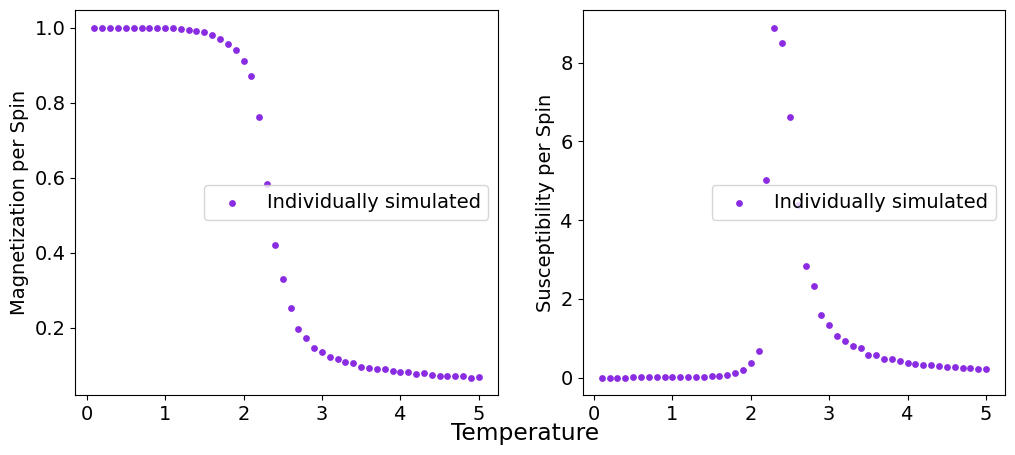

In [10]:
%matplotlib inline

fig,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].scatter(TsI, msIa/nI, s=15, color='blueviolet', label='Individually simulated')
ax[0].set_ylabel('Magnetization per Spin')
ax[0].legend()

ax[1].scatter(TsI, ssIa/nI, s=15, color='blueviolet', label='Individually simulated')
ax[1].set_ylabel('Susceptibility per Spin')
ax[1].legend()

fig.supxlabel('Temperature')
plt.show()

Now that the critical temperature has been identified, we can perform the Lee-Kosterlitz analysis on the system. We first run a large number of Monte Carlo sweeps on the system at this critical temperature, storing the values of the magnetisation after each sweep after equilibrium has been achieved, and finally making a histogram of these values of magnetisation.

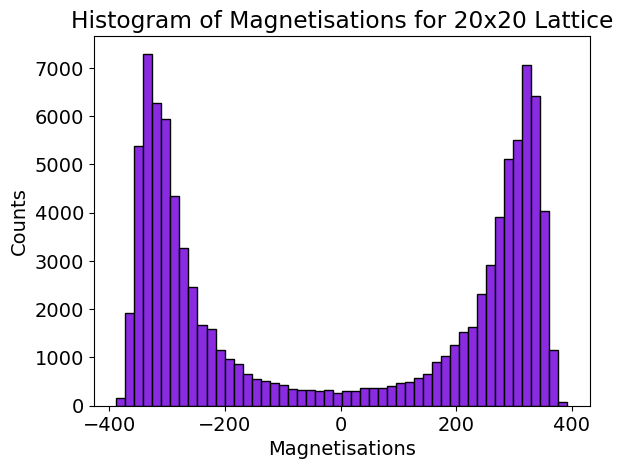

CPU times: user 1.53 s, sys: 12.3 ms, total: 1.54 s
Wall time: 1.1 s


In [11]:
%%time

_, mI = crit_temp_dataI(20, 2.27)
plt.hist(mI, color='blueviolet', bins=50, ec='black')
plt.xlabel('Magnetisations')
plt.ylabel('Counts')
plt.title('Histogram of Magnetisations for 20x20 Lattice')
plt.show()

With the magnetisation bins $M$ and corresponding counts $H(M)$ of this histogram now obtained, we can calculate the free energy $F(M,T)$,
$$F(M,T) = -T\ln(H(M)) + TM\left( \frac{1}{T} - \frac{1}{T_C} \right)$$
which, when plotted against the magnetisation $M$, should give us a curve with a double minima. We can vary $T$ until the depths of those two minima are the same, to obtain an even more precise value for the critical temperature.

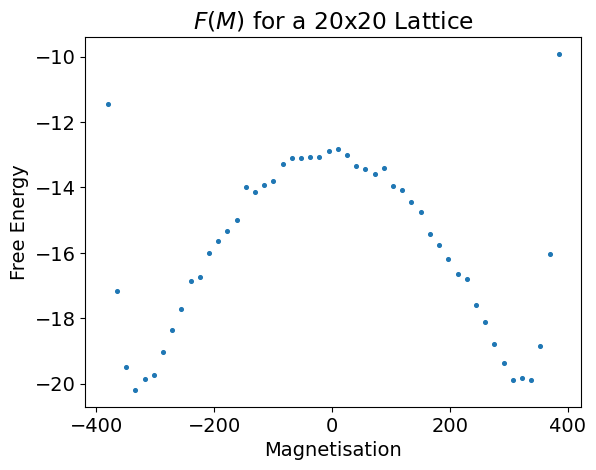

In [12]:
mIs, fIs = lee_kost(mI, t=2.27, Tc=2.27)
plt.scatter(mIs, fIs, s=7)
plt.xlabel('Magnetisation')
plt.ylabel('Free Energy')
plt.title(r'$F(M)$ for a 20x20 Lattice')
plt.show()

With the double minima now found, we can find the distance between the maximum and the two minima. For this, we fit a 10th order polynomial onto the curve, to identify these extrema as accurately as possible.

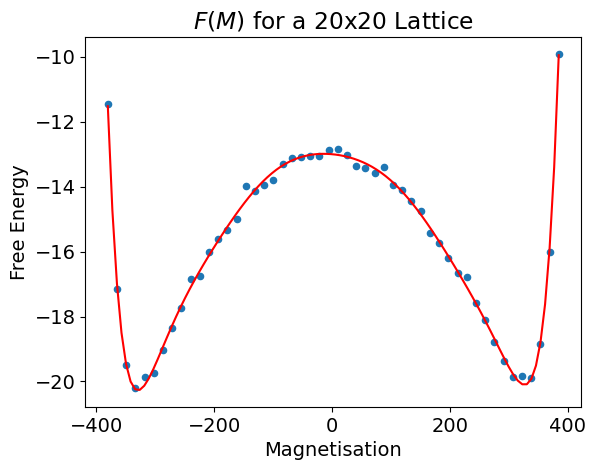

In [13]:
coeffs = np.array(np.polyfit(mIs,fIs,10))
x = np.linspace(min(mIs), max(mIs), 100)
y = np.zeros_like(x)
for i in range(len(coeffs)):
    y += coeffs[i]*(x**(10-i))

plt.scatter(mIs, fIs, s=20)
plt.plot(x,y, color='red')
plt.xlabel('Magnetisation')
plt.ylabel('Free Energy')
plt.title(r'$F(M)$ for a 20x20 Lattice')
plt.show()

With the double minima now obtained, we can observe how it changes for larger and larger lattice sizes, and characterise whatever phase transition it may represent.

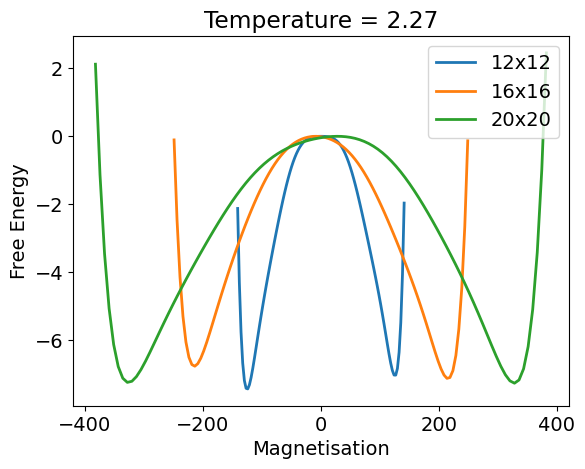

CPU times: user 12 s, sys: 51.7 ms, total: 12 s
Wall time: 11.5 s


In [14]:
%%time

ttt = 2.27
pIs = np.array([12,16,20,24,28,32,36])
dFIs = np.zeros_like(pIs, dtype=np.float64)
for i,p in enumerate(pIs):
    _, m = crit_temp_dataI(p, ttt)
    ms, fs = lee_kost(m, t=ttt, Tc=ttt)
    dF, xmax, xmin, x, y = find_dF(ms, fs)
    
    dFIs[i] = dF
    if p < 21:
        plt.plot(x, y-xmax, lw=2, label=str(p)+'x'+str(p)+'')
plt.xlabel('Magnetisation')
plt.ylabel('Free Energy')
plt.title('Temperature = '+str(ttt))
plt.legend()
plt.show()

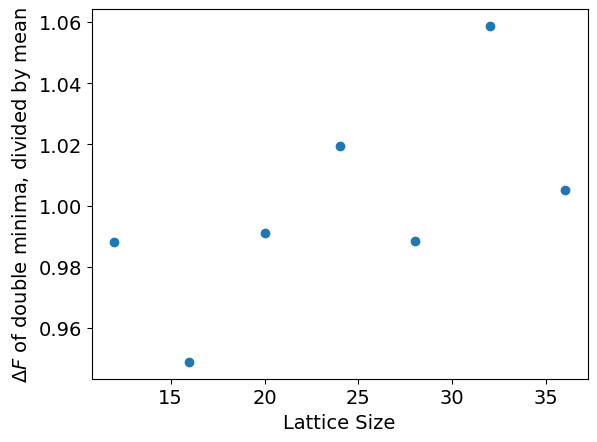

In [15]:
plt.scatter(pIs, dFIs/np.mean(dFIs))
plt.xlabel('Lattice Size')
plt.ylabel(r'$\Delta F$ of double minima, divided by mean')
plt.show()

From plotting the distance between the central maximum and minima for each of the curves obtained against the corresponding lattice size, we see that the quantity $\Delta F$ remains more or less constant with increasing lattice size, which lets us conclude that the Ising model has a second-order phase transition.

# Characterising the Phase Transition of the q-Potts Model

As with the Ising Model, we followed the same steps, using the graphs of the order parameter energy and its derivative the specific heat, both against temperature, to identify a critical temperature. Here we have done the graphs for the q-state $q=8$.

In [30]:
%%time

betas = np.linspace(0.1,2,50)   #going from a high to low temperature region with 50 points in between

avE   =np.zeros(len(betas))    #array to store average energy for each temperature value
avEsq =np.zeros_like(avE)      #array to store average energy square for each temperature value

avM   =np.zeros_like(avE)      #array to store average magnetization for each temperature value                
avMsq =np.zeros_like(avE)      #array to store average magnetization sqaure for each temperature value

cvs   =np.zeros_like(avE)       #array to store Specific heat for each temperature value                    
chis =np.zeros_like(avE)        #array to store susceptibility for each temperature value


# looping over the arrays
equil=1000 # requires equilibration time, we collect data after this
n_mcs=10_000
L=50
# q=4
q=8
J=1
for i,beta in enumerate(betas): # running over all beta values and storing the avg energy, energy square, mag, mag square
    e,m,spins=simulate(q,L, beta,J, n_mcs)
    avE[i]=np.mean(e[equil:])
    avEsq[i]=np.mean(e[equil:]**2)
    avM[i]=np.mean(m[equil:])
    avMsq[i]=np.mean(m[equil:]**2)



    #using avg energy and avg energy sq to calculate cv
    cvs[i]=(avEsq[i]-avE[i]**2)*(beta**2)

    #using avg mag and avg mag sq to calculate chi
    chis[i]=(avMsq[i]-avM[i]**2)*(beta)

CPU times: user 40.4 s, sys: 180 ms, total: 40.6 s
Wall time: 40.6 s


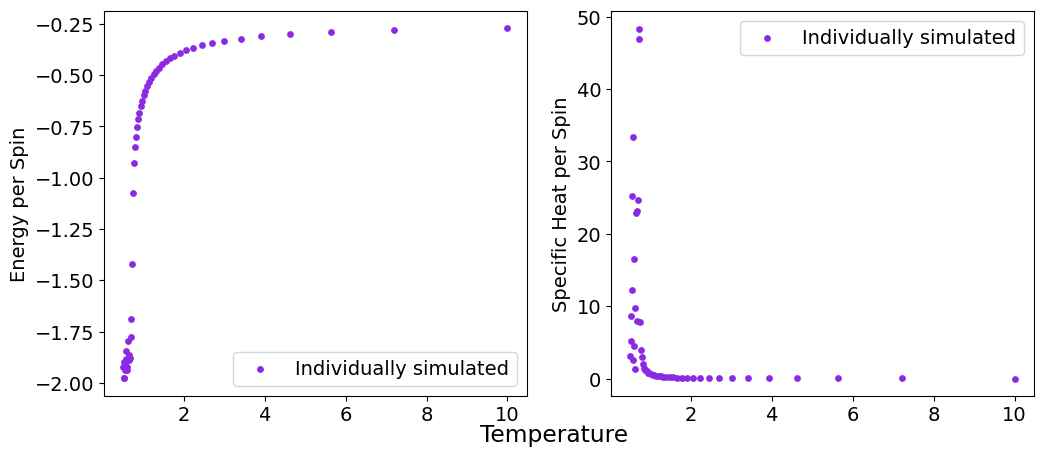

In [31]:
%matplotlib inline

fig,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].scatter(1/betas, avE/L/L, s=15, color='blueviolet', label='Individually simulated')
ax[0].set_ylabel('Energy per Spin')
ax[0].legend()

ax[1].scatter(1/betas, cvs/L/L, s=15, color='blueviolet', label='Individually simulated')
ax[1].set_ylabel('Specific Heat per Spin')
ax[1].legend()

fig.supxlabel('Temperature')
plt.show()

These graphs seem to match well with the known critical temperature $T_c = 0.745$ for an 8-state-Potts lattice. Now that we have our critical temperature, we can obtain a histogram of energies, and also perform the Lee-Kosterlitz analysis.

The data used here was pre-prepared from past runs, I use this here as it would otherwise have taken too long to run here. The .npy files have been uploaded in the supplementary .zip file.

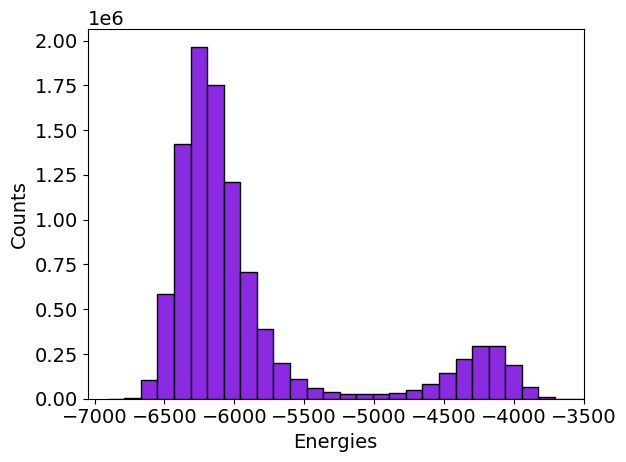

In [18]:
#Data for histogram, pre-made; these .npy files will be uploaded in the supplementary files

eQ1 = np.load('q_8_1e7_L_62_trial_2.npy')
eQ2 = np.load('q_8_1e7_L_68_trial_2.npy')
eQ3 = np.load('q_8_1e7_L_72_trial_2.npy')
eQ4 = np.load('q_8_1e7_L_76_trial_2.npy')

plt.hist(eQ1, color='blueviolet', bins=50, ec='black')
plt.xlabel('Energies')
plt.ylabel('Counts')
plt.xlim(-7_050,-3_500)
# xlim provided to focus on the visible and prominent bins, instead of seeing even the smaller anomalous bins
plt.show()

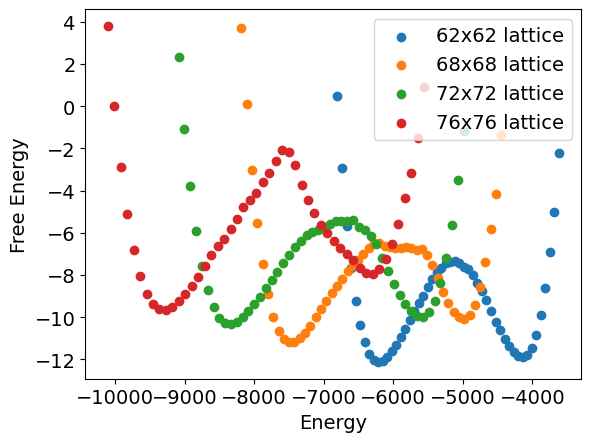

In [19]:
esQ1, fQ1 = lee_kostQ(eQ1,1/0.7405,1/0.74)
esQ2, fQ2 = lee_kostQ(eQ2,1/0.7405,1/0.74)
esQ3, fQ3 = lee_kostQ(eQ3,1/0.7405,1/0.74)
esQ4, fQ4 = lee_kostQ(eQ4,1/0.7405,1/0.74)

plt.scatter(esQ1,fQ1, label='62x62 lattice')
plt.scatter(esQ2,fQ2, label='68x68 lattice')
plt.scatter(esQ3,fQ3, label='72x72 lattice')
plt.scatter(esQ4,fQ4, label='76x76 lattice')
plt.xlabel('Energy')
plt.ylabel('Free Energy')
plt.legend()
plt.show()

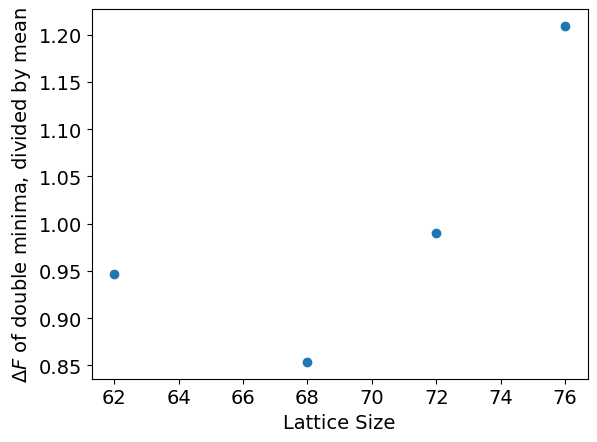

In [20]:
dFQ1 = find_dF(esQ1, fQ1)[0]
dFQ2 = find_dF(esQ2, fQ2)[0]
dFQ3 = find_dF(esQ3, fQ3)[0]
dFQ4 = find_dF(esQ4, fQ4)[0]

LQs = np.array([62,68,72,76])
dFQs = np.array([dFQ1, dFQ2, dFQ3, dFQ4])
plt.scatter(LQs, dFQs/np.mean(dFQs))
plt.xlabel('Lattice Size')
plt.ylabel(r'$\Delta F$ of double minima, divided by mean')
plt.show()

We clearly see an increase in the value of $\Delta F$ as the lattice size $L$ increases, which allows us to conclude that the q-Potts model for $q=8$ has a first-order phase transition.

# Characterising the Phase Transition of the 2D Classical Heisenberg Model

For the Heisenberg model, we again followed the same methodology, starting with identifying the order parameter and observing its behaviour over a range of temperatures. Here, despite the known lack of a phase transition, we observed the energy behaving like an order parameter, and more curiously, a peak in the specific heat. We narrowed our range of temperatures we were looking at to more accurately identify the temperature at which this peak was happening.

In [21]:
%%time

# Temperature Range
TsH = np.linspace(0.1,5,50)

# Number of particles per side
pH = 20
nH = pH*pH

# Number of Monte Carlo sweeps to be run
mcHa = 10_000

esHa = np.zeros_like(TsH)
csHa = np.zeros_like(TsH)
msHa = np.zeros_like(TsH)
ssHa = np.zeros_like(TsH)

for i,t in enumerate(TsH):
    box = np.zeros((pH,pH,3))
    box[:,:,0] = 1
    e = np.zeros(mcHa)
    mz = np.zeros(mcHa)
    for j in range(mcHa):
        box, en, mag = montecarloH(box, T=t)
        e[j] = en
        mz[j] = mag[2]
            
    e1 = np.mean(e[3000:])
    e2 = np.mean((e**2)[3000:])
    cv = (e2 - e1**2)/t/t
    esHa[i] = e1
    csHa[i] = cv
    
    m1 = np.mean(np.abs(mz)[3000:])
    m2 = np.mean((mz**2)[3000:])
    su = (m2 - m1**2)/t
    msHa[i] = m1
    ssHa[i] = su

CPU times: user 1min 18s, sys: 373 ms, total: 1min 19s
Wall time: 1min 18s


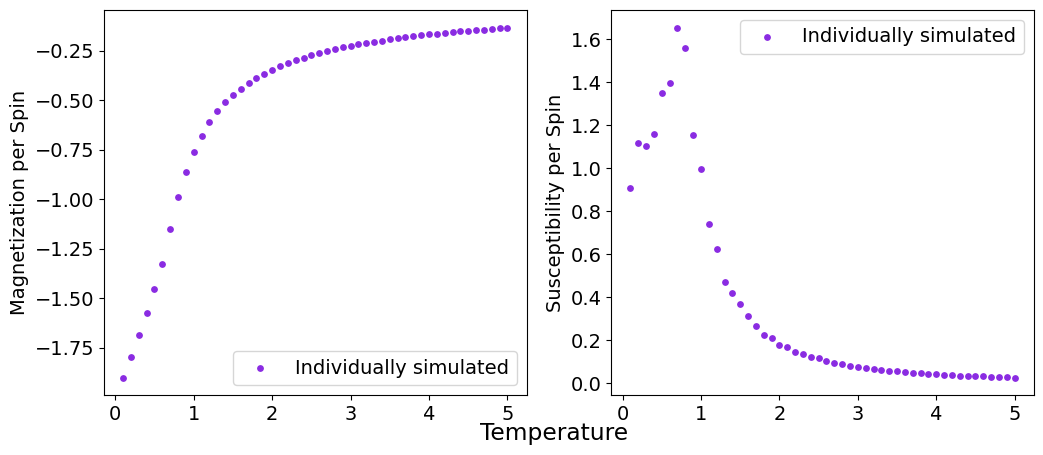

In [22]:
%matplotlib inline

fig,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].scatter(TsH, esHa/nH, s=15, color='blueviolet', label='Individually simulated')
ax[0].set_ylabel('Magnetization per Spin')
ax[0].legend()

ax[1].scatter(TsH, csHa/nH, s=15, color='blueviolet', label='Individually simulated')
ax[1].set_ylabel('Susceptibility per Spin')
ax[1].legend()

fig.supxlabel('Temperature')
plt.show()

In [23]:
%%time

# Smaller Temperature Range
TsH_ = np.linspace(0.6,1.1,100)

esHb = np.zeros_like(TsH_)
csHb = np.zeros_like(TsH_)

mcHb = 100_000

for i,t in enumerate(TsH_):
    box = np.zeros((pH,pH,3))
    box[:,:,0] = 1
    e = np.zeros(mcHb)
    for j in range(mcHb):
        box, en, _ = montecarloH(box, T=t)
        e[j] = en
            
    e1 = np.mean(e[3000:])
    e2 = np.mean((e**2)[3000:])
    cv = (e2 - e1**2)/t
    esHb[i] = e1
    csHb[i] = cv

CPU times: user 24min 48s, sys: 6.29 s, total: 24min 54s
Wall time: 24min 56s


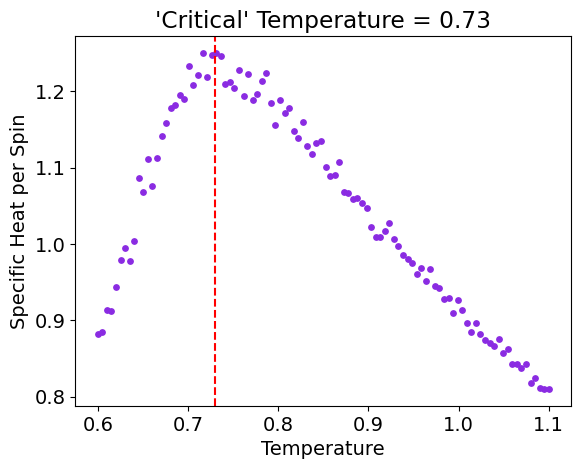

In [32]:
plt.scatter(TsH_, csHb/nH, s=15, color='blueviolet', label='Individually simulated')
plt.axvline(0.73, color='red', ls='--', label='Critical Temperature = 0.73')
plt.xlabel('Temperature')
plt.ylabel('Specific Heat per Spin')
plt.title("'Critical' Temperature = 0.73")
plt.show()

We then plotted a histogram of the energies of the system at this 'critical' temperature, and attempted Lee-Kosterlitz analysis on it. This gave us only a single minimum, not two, which would indicate the absence of a phase transitions.

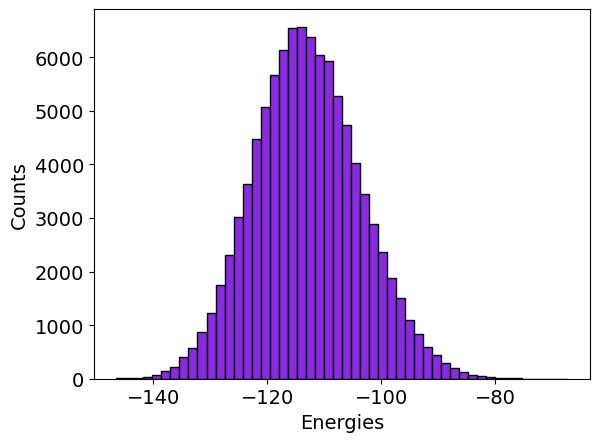

CPU times: user 3.45 s, sys: 24.7 ms, total: 3.48 s
Wall time: 2.99 s


In [25]:
%%time

eH, _ = crit_temp_dataH(10, 0.73)
plt.hist(eH, color='blueviolet', bins=50, ec='black')
plt.xlabel('Energies')
plt.ylabel('Counts')
plt.show()

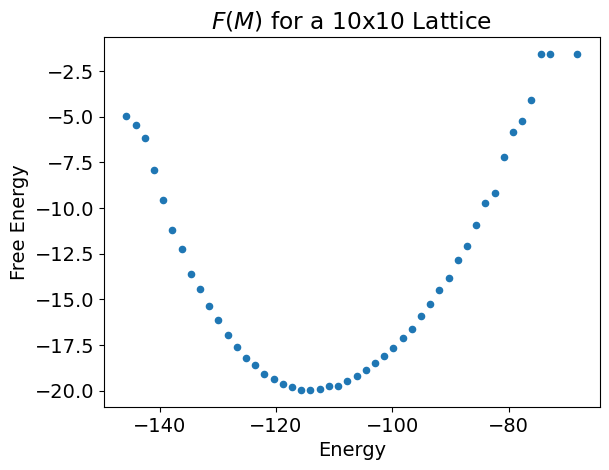

In [26]:
eHs, fHs = lee_kost(eH, t=2.27, Tc=2.27)
plt.scatter(eHs, fHs, s=20)
plt.xlabel('Energy')
plt.ylabel('Free Energy')
plt.title(r'$F(M)$ for a 10x10 Lattice')
plt.show()

To confirm this though, we performed the Lee-Kosterlitz analysis for even larger lattices, and saw single minima there as well.

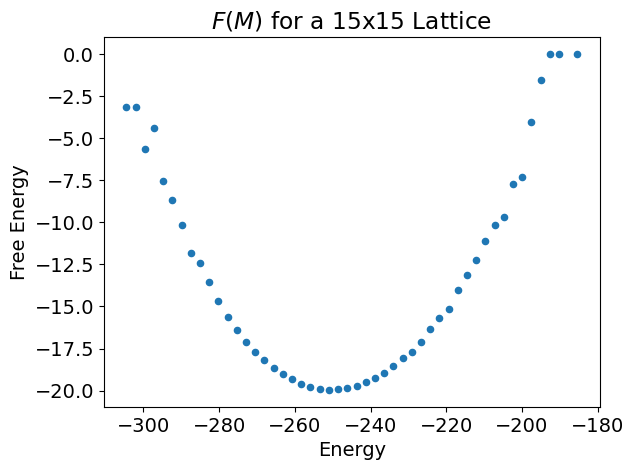

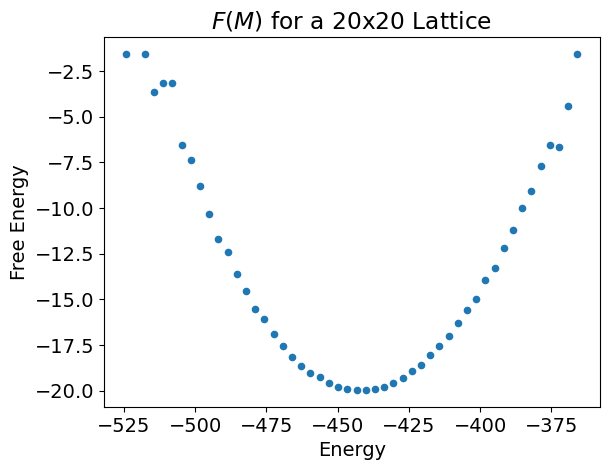

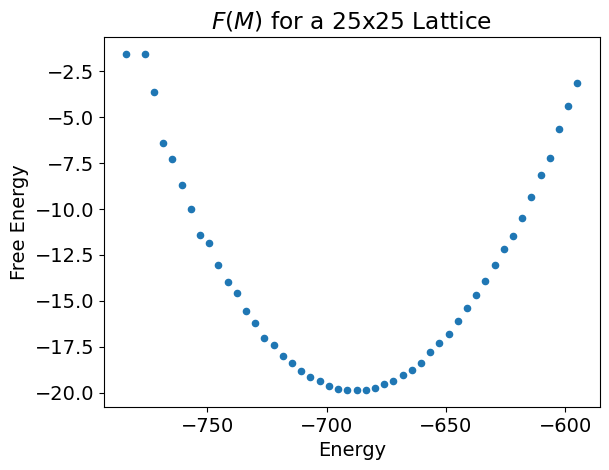

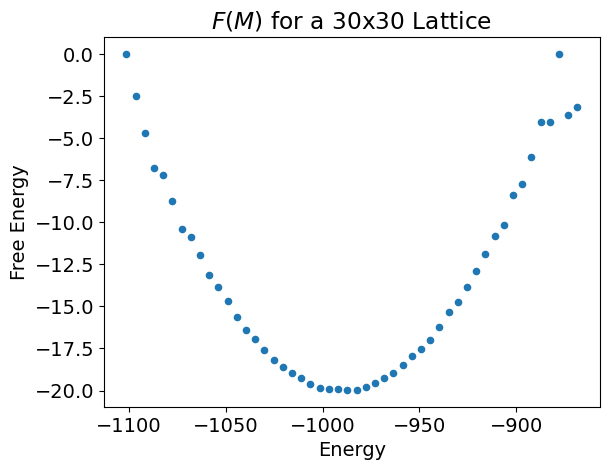

CPU times: user 1min 4s, sys: 383 ms, total: 1min 4s
Wall time: 1min 2s


In [27]:
%%time

pHs = np.array([15,20,25,30])
for i,p in enumerate(pHs):
    e, _ = crit_temp_dataH(p, 0.73)
    eHs, fHs = lee_kost(e, t=2.27, Tc=2.27)
    plt.scatter(eHs, fHs, s=20)
    plt.xlabel('Energy')
    plt.ylabel('Free Energy')
    plt.title(r'$F(M)$ for a ' + str(p) + 'x' + str(p) + ' Lattice')
    plt.show()

Thus, from the lack of double minimas in the free energy against energy plots, we can conclude that the 2D Classical Heisenberg Model does not show a phase transition.